#Load libraries

In [8]:
import torch
import torch.nn as nn
import math
import time
import numpy as np
import matplotlib.pyplot as plt
import math
import time

https://pabloinsente.github.io/the-recurrent-net

# Long Short-Term Memory (LSTM)



Shortly after the first Elman-style RNNs were trained using backpropagation
:cite:`elman1990finding`, the problems of learning long-term dependencies
(owing to vanishing and exploding gradients)
became salient, with Bengio and Hochreiter
discussing the problem
:cite:`bengio1994learning,Hochreiter.Bengio.Frasconi.ea.2001`.
Hochreiter had articulated this problem as early
as 1991 in his Master's thesis, although the results
were not widely known because the thesis was written in German.
While gradient clipping helps with exploding gradients,
handling vanishing gradients appears
to require a more elaborate solution.
One of the first and most successful techniques
for addressing vanishing gradients
came in the form of the long short-term memory (LSTM) model
due to :citet:`Hochreiter.Schmidhuber.1997`.
LSTMs resemble standard recurrent neural networks
but here each ordinary recurrent node
is replaced by a *memory cell*.
Each memory cell contains an *internal state*,
i.e., a node with a self-connected recurrent edge of fixed weight 1,
ensuring that the gradient can pass across many time steps
without vanishing or exploding.

The term "long short-term memory" comes from the following intuition.
Simple recurrent neural networks
have *long-term memory* in the form of weights.
The weights change slowly during training,
encoding general knowledge about the data.
They also have *short-term memory*
in the form of ephemeral activations,
which pass from each node to successive nodes.
The LSTM model introduces an intermediate type of storage via the memory cell.
A memory cell is a composite unit,
built from simpler nodes
in a specific connectivity pattern,
with the novel inclusion of multiplicative nodes.


## Gated Memory Cell

Each memory cell is equipped with an *internal state*
and a number of multiplicative gates that determine whether
(i) a given input should impact the internal state (the *input gate*),
(ii) the internal state should be flushed to $0$ (the *forget gate*),
and (iii) the internal state of a given neuron
should be allowed to impact the cell's output (the *output* gate).


### Gated Hidden State

The key distinction between vanilla RNNs and LSTMs
is that the latter support gating of the hidden state.
This means that we have dedicated mechanisms for
when a hidden state should be *updated* and
also for when it should be *reset*.
These mechanisms are learned and they address the concerns listed above.
For instance, if the first token is of great importance
we will learn not to update the hidden state after the first observation.
Likewise, we will learn to skip irrelevant temporary observations.
Last, we will learn to reset the latent state whenever needed.
We discuss this in detail below.

### Input Gate, Forget Gate, and Output Gate

The data feeding into the LSTM gates are
the input at the current time step and
the hidden state of the previous time step,
as illustrated in :numref:`fig_lstm_0`.
Three fully connected layers with sigmoid activation functions
compute the values of the input, forget, and output gates.
As a result of the sigmoid activation,
all values of the three gates
are in the range of $(0, 1)$.
Additionally, we require an *input node*,
typically computed with a *tanh* activation function.
Intuitively, the *input gate* determines how much
of the input node's value should be added
to the current memory cell internal state.
The *forget gate* determines whether to keep
the current value of the memory or flush it.
And the *output gate* determines whether
the memory cell should influence the output
at the current time step.


![Computing the input gate, the forget gate, and the output gate in an LSTM model.](https://github.com/d2l-ai/d2l-en-colab/blob/master/img/lstm-0.svg?raw=1)
:label:`fig_lstm_0`

Mathematically, suppose that there are $h$ hidden units,
the batch size is $n$, and the number of inputs is $d$.
Thus, the input is $\mathbf{X}_t \in \mathbb{R}^{n \times d}$
and the hidden state of the previous time step
is $\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$.
Correspondingly, the gates at time step $t$
are defined as follows: the input gate is $\mathbf{I}_t \in \mathbb{R}^{n \times h}$,
the forget gate is $\mathbf{F}_t \in \mathbb{R}^{n \times h}$,
and the output gate is $\mathbf{O}_t \in \mathbb{R}^{n \times h}$.
They are calculated as follows:

$$
\begin{aligned}
\mathbf{I}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{\textrm{xi}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hi}} + \mathbf{b}_\textrm{i}),\\
\mathbf{F}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{\textrm{xf}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hf}} + \mathbf{b}_\textrm{f}),\\
\mathbf{O}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{\textrm{xo}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{ho}} + \mathbf{b}_\textrm{o}),
\end{aligned}
$$

where $\mathbf{W}_{\textrm{xi}}, \mathbf{W}_{\textrm{xf}}, \mathbf{W}_{\textrm{xo}} \in \mathbb{R}^{d \times h}$ and $\mathbf{W}_{\textrm{hi}}, \mathbf{W}_{\textrm{hf}}, \mathbf{W}_{\textrm{ho}} \in \mathbb{R}^{h \times h}$ are weight parameters
and $\mathbf{b}_\textrm{i}, \mathbf{b}_\textrm{f}, \mathbf{b}_\textrm{o} \in \mathbb{R}^{1 \times h}$ are bias parameters.
Note that broadcasting
(see :numref:`subsec_broadcasting`)
is triggered during the summation.
We use sigmoid functions
(as introduced in :numref:`sec_mlp`)
to map the input values to the interval $(0, 1)$.


### Input Node

Next we design the memory cell.
Since we have not specified the action of the various gates yet,
we first introduce the *input node*
$\tilde{\mathbf{C}}_t \in \mathbb{R}^{n \times h}$.
Its computation is similar to that of the three gates described above,
but uses a $\tanh$ function with a value range for $(-1, 1)$ as the activation function.
This leads to the following equation at time step $t$:

$$\tilde{\mathbf{C}}_t = \textrm{tanh}(\mathbf{X}_t \mathbf{W}_{\textrm{xc}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hc}} + \mathbf{b}_\textrm{c}),$$

where $\mathbf{W}_{\textrm{xc}} \in \mathbb{R}^{d \times h}$ and $\mathbf{W}_{\textrm{hc}} \in \mathbb{R}^{h \times h}$ are weight parameters and $\mathbf{b}_\textrm{c} \in \mathbb{R}^{1 \times h}$ is a bias parameter.

A quick illustration of the input node is shown in :numref:`fig_lstm_1`.

![Computing the input node in an LSTM model.](https://github.com/d2l-ai/d2l-en-colab/blob/master/img/lstm-1.svg?raw=1)
:label:`fig_lstm_1`


### Memory Cell Internal State

In LSTMs, the input gate $\mathbf{I}_t$ governs
how much we take new data into account via $\tilde{\mathbf{C}}_t$
and the forget gate $\mathbf{F}_t$ addresses
how much of the old cell internal state $\mathbf{C}_{t-1} \in \mathbb{R}^{n \times h}$ we retain.
Using the Hadamard (elementwise) product operator $\odot$
we arrive at the following update equation:

$$\mathbf{C}_t = \mathbf{F}_t \odot \mathbf{C}_{t-1} + \mathbf{I}_t \odot \tilde{\mathbf{C}}_t.$$

If the forget gate is always 1 and the input gate is always 0,
the memory cell internal state $\mathbf{C}_{t-1}$
will remain constant forever,
passing unchanged to each subsequent time step.
However, input gates and forget gates
give the model the flexibility of being able to learn
when to keep this value unchanged
and when to perturb it in response
to subsequent inputs.
In practice, this design alleviates the vanishing gradient problem,
resulting in models that are much easier to train,
especially when facing datasets with long sequence lengths.

We thus arrive at the flow diagram in :numref:`fig_lstm_2`.

![Computing the memory cell internal state in an LSTM model.](https://github.com/d2l-ai/d2l-en-colab/blob/master/img/lstm-2.svg?raw=1)

:label:`fig_lstm_2`


### Hidden State

Last, we need to define how to compute the output
of the memory cell, i.e., the hidden state $\mathbf{H}_t \in \mathbb{R}^{n \times h}$, as seen by other layers.
This is where the output gate comes into play.
In LSTMs, we first apply $\tanh$ to the memory cell internal state
and then apply another point-wise multiplication,
this time with the output gate.
This ensures that the values of $\mathbf{H}_t$
are always in the interval $(-1, 1)$:

$$\mathbf{H}_t = \mathbf{O}_t \odot \tanh(\mathbf{C}_t).$$


Whenever the output gate is close to 1,
we allow the memory cell internal state to impact the subsequent layers uninhibited,
whereas for output gate values close to 0,
we prevent the current memory from impacting other layers of the network
at the current time step.
Note that a memory cell can accrue information
across many time steps without impacting the rest of the network
(as long as the output gate takes values close to 0),
and then suddenly impact the network at a subsequent time step
as soon as the output gate flips from values close to 0
to values close to 1. :numref:`fig_lstm_3` has a graphical illustration of the data flow.

![Computing the hidden state in an LSTM model.](https://github.com/d2l-ai/d2l-en-colab/blob/master/img/lstm-3.svg?raw=1)
:label:`fig_lstm_3`



## Implementation from Scratch

Now let's implement an LSTM from scratch.
As same as the experiments in :numref:`sec_rnn-scratch`,
we first load *The Time Machine* dataset.

### [**Initializing Model Parameters**]

Next, we need to define and initialize the model parameters.
As previously, the hyperparameter `num_hiddens`
dictates the number of hidden units.
We initialize weights following a Gaussian distribution
with 0.01 standard deviation,
and we set the biases to 0.


#Code vanila LSTM

LSTMs are the prototypical latent variable autoregressive model with nontrivial state control.
Many variants thereof have been proposed over the years, e.g., multiple layers, residual connections, different types of regularization. However, training LSTMs and other sequence models (such as GRUs) is quite costly because of the long range dependency of the sequence.
Later we will encounter alternative models such as Transformers that can be used in some cases.

In [1]:

# --- LSTM Model Definition ---

class LSTM(nn.Module):
    def __init__(self, vocab_size, num_hiddens):
        super(LSTM, self).__init__()
        self.vocab_size = vocab_size
        self.num_hiddens = num_hiddens
        self.num_inputs = vocab_size  # Typically, input size is vocab size for RNNs on text

        # Forget gate parameters: [W_hf, W_xf, b_f]
        self.W_hf = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * math.sqrt(1 / num_hiddens))
        self.W_xf = nn.Parameter(torch.randn(num_hiddens, self.num_inputs) * math.sqrt(1 / self.num_inputs))
        self.b_f = nn.Parameter(torch.zeros(num_hiddens))

        # Input gate parameters: [W_hi, W_xi, b_i]
        self.W_hi = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * math.sqrt(1 / num_hiddens))
        self.W_xi = nn.Parameter(torch.randn(num_hiddens, self.num_inputs) * math.sqrt(1 / self.num_inputs))
        self.b_i = nn.Parameter(torch.zeros(num_hiddens))

        # Candidate cell state parameters: [W_hc, W_xc, b_c]
        self.W_hc = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * math.sqrt(1 / num_hiddens))
        self.W_xc = nn.Parameter(torch.randn(num_hiddens, self.num_inputs) * math.sqrt(1 / self.num_inputs))
        self.b_c = nn.Parameter(torch.zeros(num_hiddens))

        # Output gate parameters: [W_ho, W_xo, b_o]
        self.W_ho = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * math.sqrt(1 / num_hiddens))
        self.W_xo = nn.Parameter(torch.randn(num_hiddens, self.num_inputs) * math.sqrt(1 / self.num_inputs))
        self.b_o = nn.Parameter(torch.zeros(num_hiddens))

        # Output layer parameters: [W_hq, b_q]
        self.W_hq = nn.Parameter(torch.randn(vocab_size, num_hiddens) * math.sqrt(1 / num_hiddens))
        self.b_q = nn.Parameter(torch.zeros(vocab_size))

    def forward(self, inputs, state):
        """
        Args:
            inputs: Tensor of shape (batch_size, seq_len, vocab_size)
            state: Tuple of (hidden_state H, cell_state C), each of shape (batch_size, num_hiddens)

        Returns:
            outputs: List of output tensors for each time step, each of shape (batch_size, vocab_size)
            state: Tuple of final (hidden_state H, cell_state C)
        """
        H, C = state
        outputs = []

        for X in inputs.permute(1, 0, 2):  # X shape: (batch_size, vocab_size) at each time step
            # Forget gate
            F = torch.sigmoid((H @ self.W_hf.t()) + (X @ self.W_xf.t()) + self.b_f)

            # Input gate
            I = torch.sigmoid((H @ self.W_hi.t()) + (X @ self.W_xi.t()) + self.b_i)

            # Candidate cell state
            C_tilde = torch.tanh((H @ self.W_hc.t()) + (X @ self.W_xc.t()) + self.b_c)

            # Update cell state
            C = F * C + I * C_tilde

            # Output gate
            O = torch.sigmoid((H @ self.W_ho.t()) + (X @ self.W_xo.t()) + self.b_o)

            # Update hidden state
            H = O * torch.tanh(C)

            # Compute output for this time step
            output = H @ self.W_hq.t() + self.b_q
            outputs.append(output)

        return outputs, (H, C)

# --- Helper Functions for Training ---

def get_data_shakespeare(batch_size, seq_len):
    """Downloads and prepares the tinyshakespeare dataset."""
    # This is a placeholder. You would typically use torchtext or similar.
    # For demonstration, let's create a dummy character-level dataset.
    text = "hello world hello pytorch hello lstm hello world again"
    chars = list(set(text))
    vocab_size = len(chars)
    char_to_idx = {ch: i for i, ch in enumerate(chars)}
    idx_to_char = {i: ch for i, ch in enumerate(chars)}
    data = torch.tensor([char_to_idx[ch] for ch in text], dtype=torch.long)

    # Simple one-hot encoding for input
    X = torch.nn.functional.one_hot(data, num_classes=vocab_size).float()

    dataset = torch.utils.data.TensorDataset(X[:-1], data[1:]) # (input, target)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    return dataloader, vocab_size, char_to_idx, idx_to_char

def train_lstm(model, dataloader, num_epochs, lr, device):
    """Trains the LSTM model."""
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    start_time = time.time()
    for epoch in range(num_epochs):
        total_loss = 0
        for X_batch, Y_batch in dataloader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            batch_size = X_batch.shape[0]

            # Initialize hidden state and cell state for each batch
            H = torch.zeros(batch_size, model.num_hiddens, device=device)
            C = torch.zeros(batch_size, model.num_hiddens, device=device)
            state = (H, C)

            optimizer.zero_grad()

            # Forward pass
            outputs, state = model(X_batch.unsqueeze(1), state) # Add seq_len dim
            # Concatenate outputs for loss calculation
            output_tensor = torch.stack(outputs, dim=1) # Shape: (batch_size, seq_len, vocab_size)
            loss = loss_fn(output_tensor.reshape(-1, model.vocab_size), Y_batch.reshape(-1))

            # Backward pass
            loss.backward()
            # Optional: Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f'Epoch {epoch+1}, Average Loss: {avg_loss:.4f}, Time: {time.time() - start_time:.2f}s')

# --- Main Execution ---
if __name__ == "__main__":
    # Hyperparameters
    batch_size = 32
    seq_len = 10
    num_hiddens = 256
    num_epochs = 100
    lr = 0.01
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Prepare data
    dataloader, vocab_size, char_to_idx, idx_to_char = get_data_shakespeare(batch_size, seq_len)
    print(f"Vocabulary Size: {vocab_size}")

    # Instantiate model
    lstm_model = LSTM(vocab_size=vocab_size, num_hiddens=num_hiddens)

    # Train the model
    print("Starting training...")
    train_lstm(lstm_model, dataloader, num_epochs, lr, device)
    print("Training finished.")

    # Example of using the trained model for prediction (sampling)
    def predict_next_char(model, prefix, num_predict, char_to_idx, idx_to_char, device):
        model.eval()
        state = (torch.zeros(1, model.num_hiddens, device=device),
                 torch.zeros(1, model.num_hiddens, device=device))
        output = [char_to_idx[prefix[0]]]

        for i in range(len(prefix) + num_predict - 1):
            X = torch.nn.functional.one_hot(torch.tensor([output[-1]], device=device), num_classes=model.vocab_size).float().unsqueeze(1) # Shape (1, 1, vocab_size)
            Y, state = model(X, state)
            if i < len(prefix) - 1:
                # Use the actual character from the prefix
                next_char_idx = char_to_idx[prefix[i + 1]]
            else:
                # Sample the next character based on output probabilities
                # Use argmax for deterministic prediction
                next_char_idx = int(Y[0].argmax(dim=1).item())
                # Or use torch.multinomial for probabilistic sampling:
                # probs = torch.softmax(Y[0][0], dim=0)
                # next_char_idx = int(torch.multinomial(probs, 1).item())
            output.append(next_char_idx)

        return ''.join([idx_to_char[i] for i in output])

    # Example prediction
    print("\nExample prediction:")
    prediction = predict_next_char(lstm_model, 'hello', 10, char_to_idx, idx_to_char, device)
    print(f"Input: 'hello', Prediction: '{prediction}'")


Vocabulary Size: 18
Starting training...
Epoch 1, Average Loss: 2.9051, Time: 0.12s
Epoch 2, Average Loss: 2.7801, Time: 0.12s
Epoch 3, Average Loss: 2.6889, Time: 0.13s
Epoch 4, Average Loss: 2.6024, Time: 0.14s
Epoch 5, Average Loss: 2.5057, Time: 0.15s
Epoch 6, Average Loss: 2.3756, Time: 0.16s
Epoch 7, Average Loss: 2.2582, Time: 0.16s
Epoch 8, Average Loss: 2.0955, Time: 0.17s
Epoch 9, Average Loss: 2.0202, Time: 0.18s
Epoch 10, Average Loss: 1.8518, Time: 0.19s
Epoch 11, Average Loss: 1.7237, Time: 0.19s
Epoch 12, Average Loss: 1.6791, Time: 0.20s
Epoch 13, Average Loss: 1.6055, Time: 0.21s
Epoch 14, Average Loss: 1.4495, Time: 0.22s
Epoch 15, Average Loss: 1.3767, Time: 0.23s
Epoch 16, Average Loss: 1.1533, Time: 0.23s
Epoch 17, Average Loss: 1.1684, Time: 0.24s
Epoch 18, Average Loss: 1.1475, Time: 0.25s
Epoch 19, Average Loss: 1.0181, Time: 0.26s
Epoch 20, Average Loss: 1.0659, Time: 0.27s
Epoch 21, Average Loss: 1.0458, Time: 0.27s
Epoch 22, Average Loss: 1.0396, Time: 0.28s


#Code LSTM timeseries

Training data shape: X: (790, 10), Y: (790, 10)
Test data shape: X: (190, 10), Y: (190, 10)

Starting training...
Epoch 10/100, Average Loss: 0.013123
Epoch 20/100, Average Loss: 0.012695
Epoch 30/100, Average Loss: 0.012603
Epoch 40/100, Average Loss: 0.012549
Epoch 50/100, Average Loss: 0.012591
Epoch 60/100, Average Loss: 0.012705
Epoch 70/100, Average Loss: 0.012491
Epoch 80/100, Average Loss: 0.012660
Epoch 90/100, Average Loss: 0.012431
Epoch 100/100, Average Loss: 0.012388
Training finished.


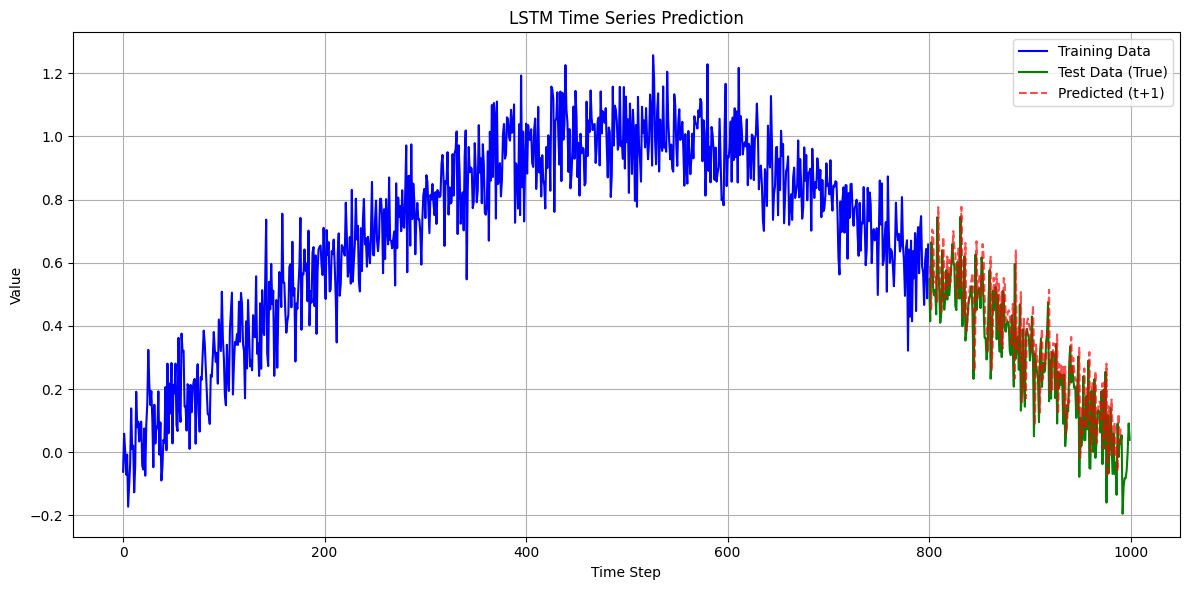


Mean Squared Error (MSE) on Test Set (t+1 prediction): 0.021735


In [6]:

# --- LSTM Model Definition ---

class LSTM(nn.Module):
    def __init__(self, input_size, num_hiddens):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.num_hiddens = num_hiddens

        # Forget gate parameters: [W_hf, W_xf, b_f]
        self.W_hf = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * math.sqrt(1 / num_hiddens))
        self.W_xf = nn.Parameter(torch.randn(num_hiddens, input_size) * math.sqrt(1 / input_size))
        self.b_f = nn.Parameter(torch.zeros(num_hiddens))

        # Input gate parameters: [W_hi, W_xi, b_i]
        self.W_hi = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * math.sqrt(1 / num_hiddens))
        self.W_xi = nn.Parameter(torch.randn(num_hiddens, input_size) * math.sqrt(1 / input_size))
        self.b_i = nn.Parameter(torch.zeros(num_hiddens))

        # Candidate cell state parameters: [W_hc, W_xc, b_c]
        self.W_hc = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * math.sqrt(1 / num_hiddens))
        self.W_xc = nn.Parameter(torch.randn(num_hiddens, input_size) * math.sqrt(1 / input_size))
        self.b_c = nn.Parameter(torch.zeros(num_hiddens))

        # Output gate parameters: [W_ho, W_xo, b_o]
        self.W_ho = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * math.sqrt(1 / num_hiddens))
        self.W_xo = nn.Parameter(torch.randn(num_hiddens, input_size) * math.sqrt(1 / input_size))
        self.b_o = nn.Parameter(torch.zeros(num_hiddens))

        # Output layer parameters: [W_hq, b_q]
        self.W_hq = nn.Parameter(torch.randn(input_size, num_hiddens) * math.sqrt(1 / num_hiddens))
        self.b_q = nn.Parameter(torch.zeros(input_size))

    def forward(self, inputs, state):
        """
        Args:
            inputs: Tensor of shape (batch_size, seq_len, input_size)
            state: Tuple of (hidden_state H, cell_state C), each of shape (batch_size, num_hiddens)

        Returns:
            outputs: Tensor of shape (batch_size, seq_len, input_size) containing all outputs
            state: Tuple of final (hidden_state H, cell_state C)
        """
        H, C = state
        batch_size, seq_len, _ = inputs.shape
        outputs = torch.zeros(batch_size, seq_len, self.input_size, device=inputs.device)

        for t in range(seq_len):
            X = inputs[:, t, :]

            F = torch.sigmoid((H @ self.W_hf.t()) + (X @ self.W_xf.t()) + self.b_f)
            I = torch.sigmoid((H @ self.W_hi.t()) + (X @ self.W_xi.t()) + self.b_i)
            C_tilde = torch.tanh((H @ self.W_hc.t()) + (X @ self.W_xc.t()) + self.b_c)
            C = F * C + I * C_tilde
            O = torch.sigmoid((H @ self.W_ho.t()) + (X @ self.W_xo.t()) + self.b_o)
            H = O * torch.tanh(C)
            output = H @ self.W_hq.t() + self.b_q
            outputs[:, t, :] = output

        return outputs, (H, C)

# --- Helper Functions for Data and Training ---

def generate_time_series(length, freq=0.1, noise_level=0.1):
    """Generates a simple noisy sine wave time series."""
    time_steps = np.linspace(0, 10 * np.pi, length)
    series = np.sin(freq * time_steps) + np.random.normal(scale=noise_level, size=length)
    return series

def create_dataset(series, seq_len):
    """Creates input-output pairs for training."""
    X, Y = [], []
    for i in range(len(series) - seq_len):
        X.append(series[i:i + seq_len])
        Y.append(series[i + 1:i + seq_len + 1]) # Predict the next sequence
    return np.array(X), np.array(Y)

def train_lstm(model, X_train, Y_train, num_epochs, lr, device, batch_size=32):
    """Trains the LSTM model."""
    model.to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    dataset = torch.utils.data.TensorDataset(
        torch.tensor(X_train, dtype=torch.float32).to(device),
        torch.tensor(Y_train, dtype=torch.float32).to(device)
    )
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        total_loss = 0
        for X_batch, Y_batch in dataloader:
            batch_size_current = X_batch.shape[0]

            H = torch.zeros(batch_size_current, model.num_hiddens, device=device)
            C = torch.zeros(batch_size_current, model.num_hiddens, device=device)
            state = (H, C)

            optimizer.zero_grad()

            outputs, state = model(X_batch.unsqueeze(-1), state)
            loss = loss_fn(outputs.squeeze(-1), Y_batch)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.6f}')

# --- Main Execution ---
if __name__ == "__main__":
    # --- Data Generation ---
    total_length = 1000
    seq_len = 10
    original_series = generate_time_series(total_length)

    # Split data
    split_idx = int(0.8 * total_length)
    train_series = original_series[:split_idx]
    test_series = original_series[split_idx:]

    X_train, Y_train = create_dataset(train_series, seq_len)
    X_test, Y_test = create_dataset(test_series, seq_len)

    print(f"Training data shape: X: {X_train.shape}, Y: {Y_train.shape}")
    print(f"Test data shape: X: {X_test.shape}, Y: {Y_test.shape}")

    # --- Model Setup ---
    input_size = 1
    num_hiddens = 32
    num_epochs = 100
    lr = 0.01
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    lstm_model = LSTM(input_size=input_size, num_hiddens=num_hiddens)

    # --- Training ---
    print("\nStarting training...")
    train_lstm(lstm_model, X_train, Y_train, num_epochs, lr, device)
    print("Training finished.")

    # --- Prediction ---
    lstm_model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1).to(device)

        batch_size_test = X_test_tensor.shape[0]
        H = torch.zeros(batch_size_test, lstm_model.num_hiddens, device=device)
        C = torch.zeros(batch_size_test, lstm_model.num_hiddens, device=device)
        state = (H, C)

        predictions_tensor, _ = lstm_model(X_test_tensor, state)
        predictions = predictions_tensor.squeeze(-1).cpu().numpy()

    # --- Plotting ---
    train_time_steps = np.arange(len(train_series))
    # The test series starts after the training series
    full_test_time_steps = np.arange(len(train_series), len(train_series) + len(test_series))
    # The predictions correspond to Y_test, which starts from test_series[1]
    # So, pred_time_steps[0] corresponds to full_test_time_steps[1]
    # Length of predictions is len(test_series) - seq_len
    # Length of Y_test is len(test_series) - seq_len
    # Y_test[:, 0] corresponds to the first predicted value for each sequence window
    # These values are test_series[1], test_series[2], ..., test_series[len(test_series)-seq_len]
    # Their indices in the full original_series are [len(train_series) + 1, len(train_series) + 2, ..., len(train_series) + len(test_series) - seq_len]
    # So, pred_time_steps should be [len(train_series) + 1, len(train_series) + 2, ..., len(train_series) + len(test_series) - seq_len]
    pred_time_steps = full_test_time_steps[1:-seq_len+1] # Start from index 1 of the test series view, end before the last seq_len-1 elements

    plt.figure(figsize=(12, 6))
    plt.plot(train_time_steps, train_series, label='Training Data', color='blue')
    plt.plot(full_test_time_steps, test_series, label='Test Data (True)', color='green')

    if len(predictions) > 0 and len(pred_time_steps) == len(predictions):
        plt.plot(pred_time_steps, predictions[:, 0], label='Predicted (t+1)', color='red', linestyle='--', alpha=0.7)
    else:
        print(f"Shape mismatch for plotting: pred_time_steps shape: {pred_time_steps.shape}, predictions[:, 0] shape: {predictions[:, 0].shape if len(predictions) > 0 else 'N/A'}")

    plt.title('LSTM Time Series Prediction')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Optional: Calculate Error ---
    from sklearn.metrics import mean_squared_error
    if len(predictions) > 0 and len(pred_time_steps) == len(predictions):
        mse = mean_squared_error(Y_test[:, 0], predictions[:, 0])
        print(f"\nMean Squared Error (MSE) on Test Set (t+1 prediction): {mse:.6f}")
    else:
        print("\nCould not calculate MSE due to shape mismatch.")

# code Gated LSTM

Training data shape: X: (790, 10), Y: (790, 10)
Test data shape: X: (190, 10), Y: (190, 10)

Starting LSTM training...
Epoch 10/100, Average Loss: 0.011521
Epoch 20/100, Average Loss: 0.011251
Epoch 30/100, Average Loss: 0.011178
Epoch 40/100, Average Loss: 0.011254
Epoch 50/100, Average Loss: 0.011103
Epoch 60/100, Average Loss: 0.011134
Epoch 70/100, Average Loss: 0.011014
Epoch 80/100, Average Loss: 0.011094
Epoch 90/100, Average Loss: 0.011068
Epoch 100/100, Average Loss: 0.010856
LSTM Training finished.
LSTM elapsed time: 31.944788 seconds

Starting GRU training...
Epoch 10/100, Average Loss: 0.011423
Epoch 20/100, Average Loss: 0.011511
Epoch 30/100, Average Loss: 0.011315
Epoch 40/100, Average Loss: 0.011257
Epoch 50/100, Average Loss: 0.011209
Epoch 60/100, Average Loss: 0.011357
Epoch 70/100, Average Loss: 0.011157
Epoch 80/100, Average Loss: 0.011341
Epoch 90/100, Average Loss: 0.011200
Epoch 100/100, Average Loss: 0.011131
GRU Training finished.
GRU elapsed time: 27.381312 s

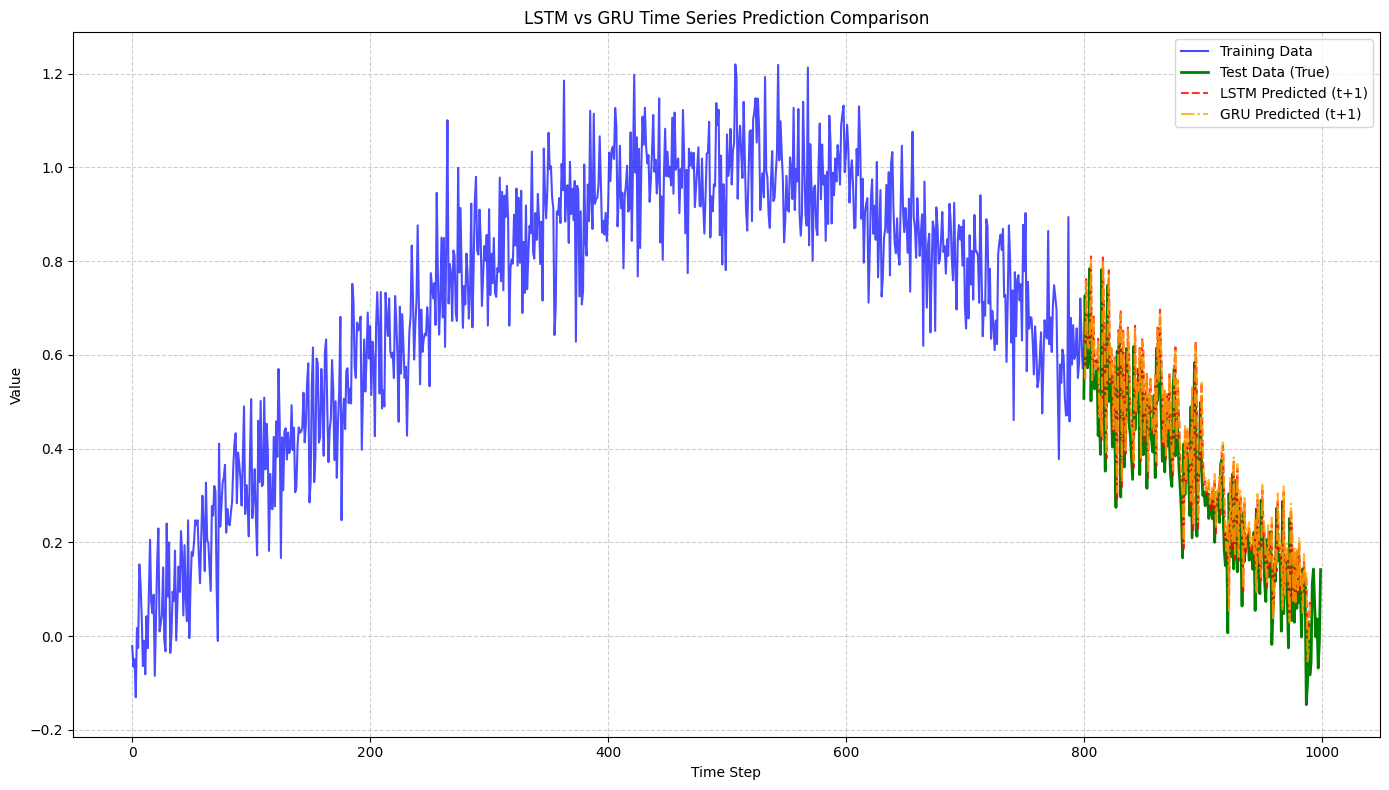


LSTM Mean Squared Error (MSE) on Test Set (t+1 prediction): 0.019941
GRU Mean Squared Error (MSE) on Test Set (t+1 prediction): 0.020053

Comparison Summary:
The LSTM model performed slightly better with a lower MSE (0.019941 vs 0.020053).

Note: Performance can vary significantly with different hyperparameters (e.g., num_hiddens, epochs, lr), data characteristics, and random initialization.


In [9]:
# --- LSTM Model Definition ---

class LSTM(nn.Module):
    def __init__(self, input_size, num_hiddens):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.num_hiddens = num_hiddens

        # Forget gate parameters: [W_hf, W_xf, b_f]
        self.W_hf = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * math.sqrt(1 / num_hiddens))
        self.W_xf = nn.Parameter(torch.randn(num_hiddens, input_size) * math.sqrt(1 / input_size))
        self.b_f = nn.Parameter(torch.zeros(num_hiddens))

        # Input gate parameters: [W_hi, W_xi, b_i]
        self.W_hi = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * math.sqrt(1 / num_hiddens))
        self.W_xi = nn.Parameter(torch.randn(num_hiddens, input_size) * math.sqrt(1 / input_size))
        self.b_i = nn.Parameter(torch.zeros(num_hiddens))

        # Candidate cell state parameters: [W_hc, W_xc, b_c]
        self.W_hc = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * math.sqrt(1 / num_hiddens))
        self.W_xc = nn.Parameter(torch.randn(num_hiddens, input_size) * math.sqrt(1 / input_size))
        self.b_c = nn.Parameter(torch.zeros(num_hiddens))

        # Output gate parameters: [W_ho, W_xo, b_o]
        self.W_ho = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * math.sqrt(1 / num_hiddens))
        self.W_xo = nn.Parameter(torch.randn(num_hiddens, input_size) * math.sqrt(1 / input_size))
        self.b_o = nn.Parameter(torch.zeros(num_hiddens))

        # Output layer parameters: [W_hq, b_q]
        self.W_hq = nn.Parameter(torch.randn(input_size, num_hiddens) * math.sqrt(1 / num_hiddens))
        self.b_q = nn.Parameter(torch.zeros(input_size))

    def forward(self, inputs, state):
        """
        Args:
            inputs: Tensor of shape (batch_size, seq_len, input_size)
            state: Tuple of (hidden_state H, cell_state C), each of shape (batch_size, num_hiddens)

        Returns:
            outputs: Tensor of shape (batch_size, seq_len, input_size) containing all outputs
            state: Tuple of final (hidden_state H, cell_state C)
        """
        H, C = state
        batch_size, seq_len, _ = inputs.shape
        outputs = torch.zeros(batch_size, seq_len, self.input_size, device=inputs.device)

        for t in range(seq_len):
            X = inputs[:, t, :]

            F = torch.sigmoid((H @ self.W_hf.t()) + (X @ self.W_xf.t()) + self.b_f)
            I = torch.sigmoid((H @ self.W_hi.t()) + (X @ self.W_xi.t()) + self.b_i)
            C_tilde = torch.tanh((H @ self.W_hc.t()) + (X @ self.W_xc.t()) + self.b_c)
            C = F * C + I * C_tilde
            O = torch.sigmoid((H @ self.W_ho.t()) + (X @ self.W_xo.t()) + self.b_o)
            H = O * torch.tanh(C)
            output = H @ self.W_hq.t() + self.b_q
            outputs[:, t, :] = output

        return outputs, (H, C)

# --- GRU Model Definition ---

class GRU(nn.Module):
    def __init__(self, input_size, num_hiddens):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.num_hiddens = num_hiddens

        # Update gate parameters: [W_hu, W_xu, b_u]
        self.W_hu = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * math.sqrt(1 / num_hiddens))
        self.W_xu = nn.Parameter(torch.randn(num_hiddens, input_size) * math.sqrt(1 / input_size))
        self.b_u = nn.Parameter(torch.zeros(num_hiddens))

        # Reset gate parameters: [W_hr, W_xr, b_r]
        self.W_hr = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * math.sqrt(1 / num_hiddens))
        self.W_xr = nn.Parameter(torch.randn(num_hiddens, input_size) * math.sqrt(1 / input_size))
        self.b_r = nn.Parameter(torch.zeros(num_hiddens))

        # Candidate hidden state parameters: [W_hh, W_xh, b_h]
        self.W_hh = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * math.sqrt(1 / num_hiddens))
        self.W_xh = nn.Parameter(torch.randn(num_hiddens, input_size) * math.sqrt(1 / input_size))
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))

        # Output layer parameters: [W_hq, b_q]
        self.W_hq = nn.Parameter(torch.randn(input_size, num_hiddens) * math.sqrt(1 / num_hiddens))
        self.b_q = nn.Parameter(torch.zeros(input_size))

    def forward(self, inputs, state):
        """
        Args:
            inputs: Tensor of shape (batch_size, seq_len, input_size)
            state: Hidden state H, shape (batch_size, num_hiddens)

        Returns:
            outputs: Tensor of shape (batch_size, seq_len, input_size) containing all outputs
            state: Final hidden state H, shape (batch_size, num_hiddens)
        """
        H = state
        batch_size, seq_len, _ = inputs.shape
        outputs = torch.zeros(batch_size, seq_len, self.input_size, device=inputs.device)

        for t in range(seq_len):
            X = inputs[:, t, :]

            # Update gate
            U = torch.sigmoid((H @ self.W_hu.t()) + (X @ self.W_xu.t()) + self.b_u)
            # Reset gate
            R = torch.sigmoid((H @ self.W_hr.t()) + (X @ self.W_xr.t()) + self.b_r)
            # Candidate hidden state
            H_tilde = torch.tanh((R * H @ self.W_hh.t()) + (X @ self.W_xh.t()) + self.b_h)
            # Update hidden state
            H = U * H + (1 - U) * H_tilde

            # Compute output for this time step
            output = H @ self.W_hq.t() + self.b_q
            outputs[:, t, :] = output

        return outputs, H

# --- Helper Functions for Data and Training ---

def generate_time_series(length, freq=0.1, noise_level=0.1):
    """Generates a simple noisy sine wave time series."""
    time_steps = np.linspace(0, 10 * np.pi, length)
    series = np.sin(freq * time_steps) + np.random.normal(scale=noise_level, size=length)
    return series

def create_dataset(series, seq_len):
    """Creates input-output pairs for training."""
    X, Y = [], []
    for i in range(len(series) - seq_len):
        X.append(series[i:i + seq_len])
        Y.append(series[i + 1:i + seq_len + 1]) # Predict the next sequence
    return np.array(X), np.array(Y)

def train_model(model, X_train, Y_train, num_epochs, lr, device, batch_size=32):
    """Trains the given model (LSTM or GRU)."""
    model.to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    dataset = torch.utils.data.TensorDataset(
        torch.tensor(X_train, dtype=torch.float32).to(device),
        torch.tensor(Y_train, dtype=torch.float32).to(device)
    )
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        total_loss = 0
        for X_batch, Y_batch in dataloader:
            batch_size_current = X_batch.shape[0]

            if isinstance(model, LSTM):
                # Initialize hidden state and cell state for LSTM
                H = torch.zeros(batch_size_current, model.num_hiddens, device=device)
                C = torch.zeros(batch_size_current, model.num_hiddens, device=device)
                state = (H, C)
            elif isinstance(model, GRU):
                # Initialize hidden state for GRU
                H = torch.zeros(batch_size_current, model.num_hiddens, device=device)
                state = H

            optimizer.zero_grad()

            outputs, _ = model(X_batch.unsqueeze(-1), state)
            loss = loss_fn(outputs.squeeze(-1), Y_batch)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.6f}')

def predict_model(model, X_test, device):
    """Makes predictions using the given model (LSTM or GRU)."""
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1).to(device)
        batch_size_test = X_test_tensor.shape[0]

        if isinstance(model, LSTM):
            H = torch.zeros(batch_size_test, model.num_hiddens, device=device)
            C = torch.zeros(batch_size_test, model.num_hiddens, device=device)
            state = (H, C)
        elif isinstance(model, GRU):
            H = torch.zeros(batch_size_test, model.num_hiddens, device=device)
            state = H

        predictions_tensor, _ = model(X_test_tensor, state)
        predictions = predictions_tensor.squeeze(-1).cpu().numpy()

    return predictions

# --- Main Execution ---
if __name__ == "__main__":
    # --- Data Generation ---
    total_length = 1000
    seq_len = 10
    original_series = generate_time_series(total_length)

    # Split data
    split_idx = int(0.8 * total_length)
    train_series = original_series[:split_idx]
    test_series = original_series[split_idx:]

    X_train, Y_train = create_dataset(train_series, seq_len)
    X_test, Y_test = create_dataset(test_series, seq_len)

    print(f"Training data shape: X: {X_train.shape}, Y: {Y_train.shape}")
    print(f"Test data shape: X: {X_test.shape}, Y: {Y_test.shape}")

    # --- Model Setup ---
    input_size = 1
    num_hiddens = 32
    num_epochs = 100
    lr = 0.01
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # --- Initialize Models ---
    lstm_model = LSTM(input_size=input_size, num_hiddens=num_hiddens)
    gru_model = GRU(input_size=input_size, num_hiddens=num_hiddens)

    # --- Training ---

    start_time = time.perf_counter()
    print("\nStarting LSTM training...")
    train_model(lstm_model, X_train, Y_train, num_epochs, lr, device)
    print("LSTM Training finished.")
    # Record the end time
    end_time = time.perf_counter()

    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time
    print(f"LSTM elapsed time: {elapsed_time:.6f} seconds")


    start_time = time.perf_counter()
    print("\nStarting GRU training...")
    train_model(gru_model, X_train, Y_train, num_epochs, lr, device)
    print("GRU Training finished.")

    end_time = time.perf_counter()
    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time
    print(f"GRU elapsed time: {elapsed_time:.6f} seconds")

    # --- Prediction ---
    lstm_predictions = predict_model(lstm_model, X_test, device)
    gru_predictions = predict_model(gru_model, X_test, device)

    # --- Plotting ---
    train_time_steps = np.arange(len(train_series))
    full_test_time_steps = np.arange(len(train_series), len(train_series) + len(test_series))
    pred_time_steps = full_test_time_steps[1:-seq_len+1] # Corrected time steps for predictions

    plt.figure(figsize=(14, 8))
    plt.plot(train_time_steps, train_series, label='Training Data', color='blue', alpha=0.7)
    plt.plot(full_test_time_steps, test_series, label='Test Data (True)', color='green', linewidth=2)

    if len(lstm_predictions) > 0 and len(pred_time_steps) == len(lstm_predictions):
        plt.plot(pred_time_steps, lstm_predictions[:, 0], label='LSTM Predicted (t+1)', color='red', linestyle='--', alpha=0.8)
    else:
        print(f"LSTM: Shape mismatch for plotting: pred_time_steps shape: {pred_time_steps.shape}, predictions[:, 0] shape: {lstm_predictions[:, 0].shape if len(lstm_predictions) > 0 else 'N/A'}")

    if len(gru_predictions) > 0 and len(pred_time_steps) == len(gru_predictions):
        plt.plot(pred_time_steps, gru_predictions[:, 0], label='GRU Predicted (t+1)', color='orange', linestyle='-.', alpha=0.8)
    else:
        print(f"GRU: Shape mismatch for plotting: pred_time_steps shape: {pred_time_steps.shape}, predictions[:, 0] shape: {gru_predictions[:, 0].shape if len(gru_predictions) > 0 else 'N/A'}")

    plt.title('LSTM vs GRU Time Series Prediction Comparison')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # --- Calculate and Print Errors ---
    from sklearn.metrics import mean_squared_error
    if len(lstm_predictions) > 0 and len(pred_time_steps) == len(lstm_predictions):
        lstm_mse = mean_squared_error(Y_test[:, 0], lstm_predictions[:, 0])
        print(f"\nLSTM Mean Squared Error (MSE) on Test Set (t+1 prediction): {lstm_mse:.6f}")
    else:
        print("\nCould not calculate LSTM MSE due to shape mismatch.")

    if len(gru_predictions) > 0 and len(pred_time_steps) == len(gru_predictions):
        gru_mse = mean_squared_error(Y_test[:, 0], gru_predictions[:, 0])
        print(f"GRU Mean Squared Error (MSE) on Test Set (t+1 prediction): {gru_mse:.6f}")
    else:
        print("Could not calculate GRU MSE due to shape mismatch.")

    print("\nComparison Summary:")
    if 'lstm_mse' in locals() and 'gru_mse' in locals():
        if lstm_mse < gru_mse:
            print(f"The LSTM model performed slightly better with a lower MSE ({lstm_mse:.6f} vs {gru_mse:.6f}).")
        elif gru_mse < lstm_mse:
            print(f"The GRU model performed slightly better with a lower MSE ({gru_mse:.6f} vs {lstm_mse:.6f}).")
        else:
            print("Both models achieved the same MSE.")
    print("\nNote: Performance can vary significantly with different hyperparameters (e.g., num_hiddens, epochs, lr), data characteristics, and random initialization.")